In [64]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.stats import norm

from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [3]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [4]:
print(names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [5]:
print(data.shape)

(15, 7819)


## ra-dec

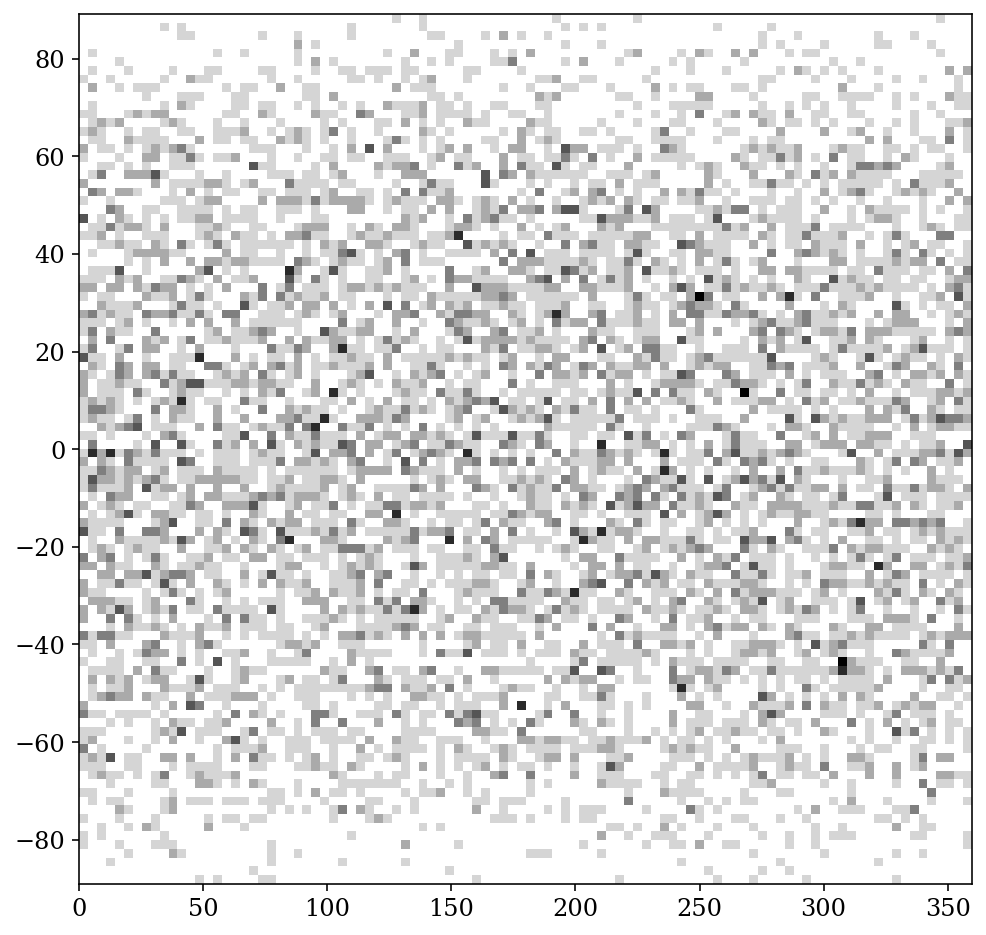

In [6]:
ra = data[3].astype(float)
dec = data[4].astype(float)
#plt.scatter(ra, dec, c = 'k', alpha = 0.3)
plt.hist2d(ra, dec, bins = 100, cmap = 'binary')
plt.show()

no clusters? check with a uniform distribution

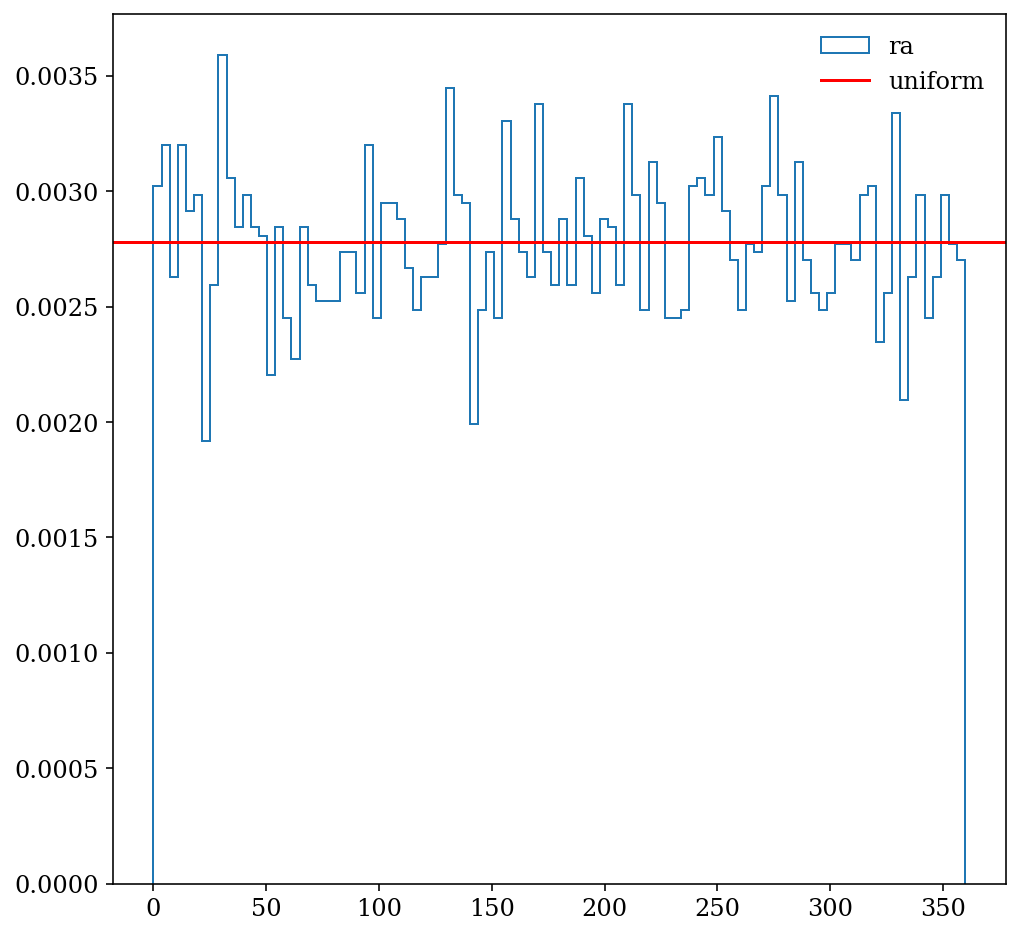

In [7]:
plt.hist(ra, bins = 100, density = True, histtype = 'step', label ='ra')
plt.axhline(1/(ra.max() - ra.min()), c = 'r', label = 'uniform')
plt.legend(frameon = False)
plt.show()

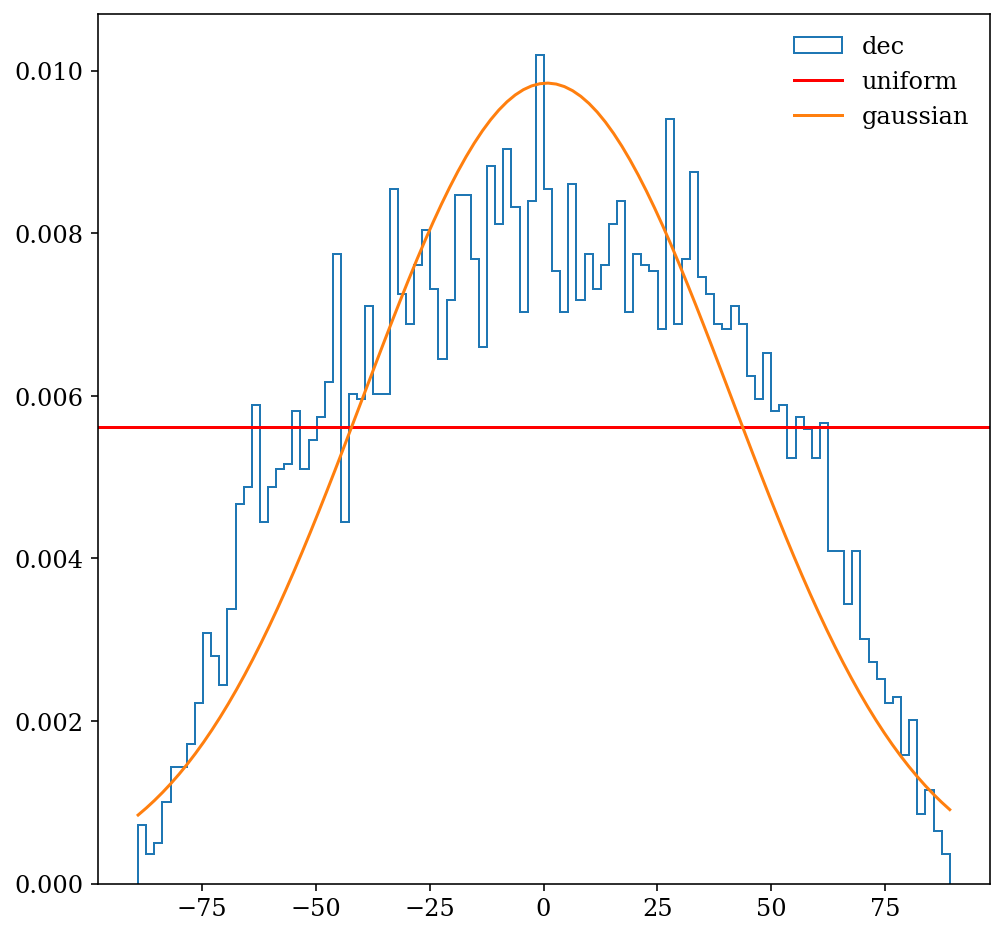

In [8]:
plt.hist(dec, bins = 100, density = True, histtype = 'step', label ='dec')
mu, scale = norm.fit(dec)
gauss = norm(mu, scale)

grid = np.linspace(dec.min(), dec.max(), 100)

plt.axhline(1/(dec.max() - dec.min()), c = 'r', label = 'uniform')
plt.plot(grid, gauss.pdf(grid), label = 'gaussian')

plt.legend(frameon = False)
plt.show()

uniform in rightascension, neither uniform nor gaussian in declination

## T90-fluence

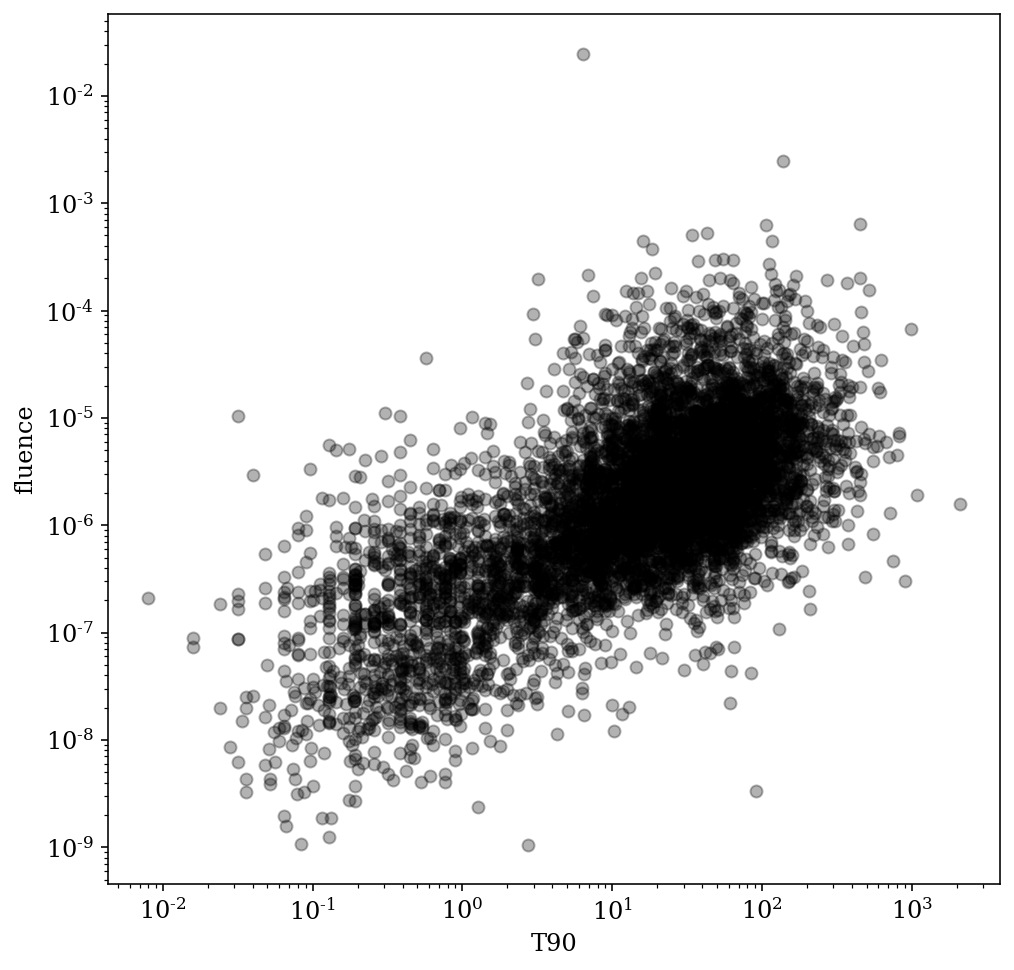

In [61]:
T90 = data[6].astype(float)
fluence = data[9].astype(float)

mask = (T90 > 0) & (fluence > 0)
#mask = (T90 > -999) & (fluence > -999)

plt.scatter(T90[mask], fluence[mask], c = 'k', alpha = 0.3)

plt.xlabel('T90')
plt.ylabel('fluence')
plt.loglog()
plt.show()

### check for clusters:

In [62]:
# K means with 2 clusters
n_clusters = 2
clf = KMeans(n_clusters = n_clusters)

X = np.vstack([np.log10(T90[mask]), np.log10(fluence[mask])]).T #right shape for the fit module
clf.fit(X)
centers = clf.cluster_centers_ 
labels = clf.predict(X)

centers

array([[ 1.53508462, -5.47354665],
       [ 0.07308521, -6.74755254]])

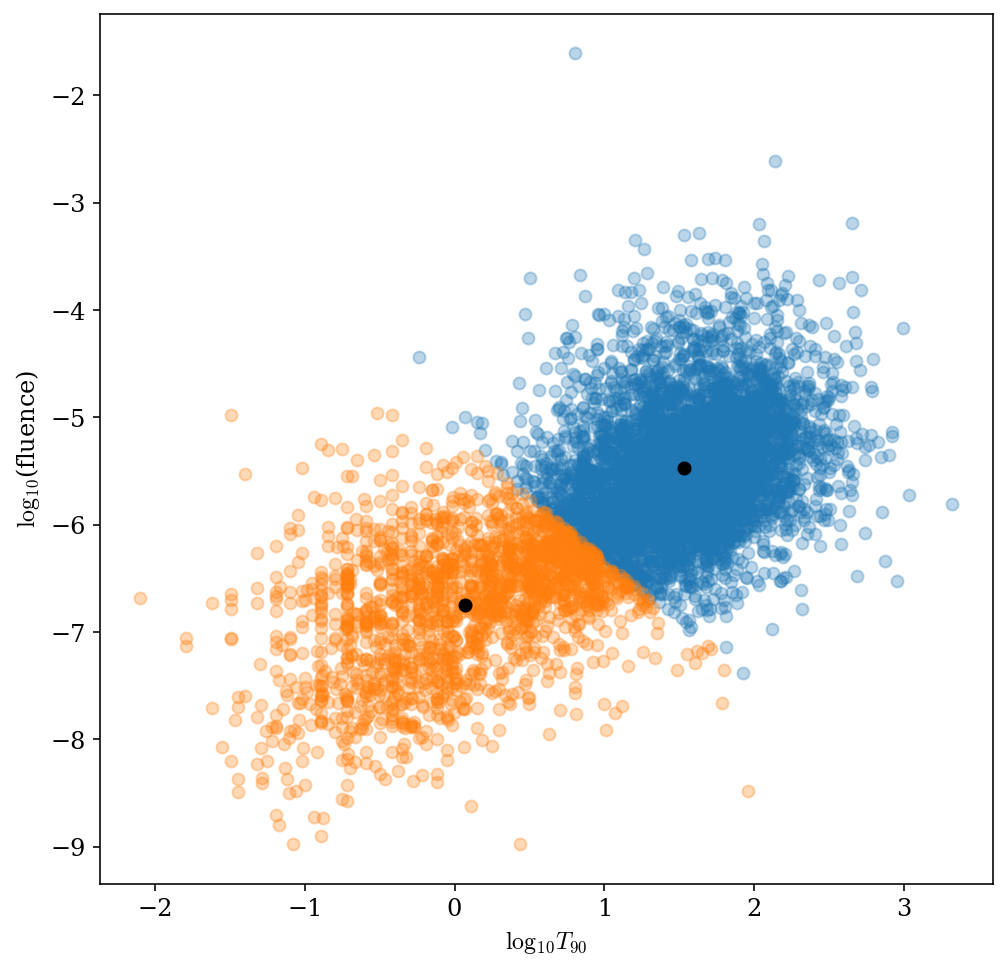

In [63]:
plt.figure()
for i in range(n_clusters):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], alpha = 0.3)
plt.scatter(centers[:, 0], centers[:, 1], c='k')

plt.xlabel(r'$\log_{10}T_{90}$')
plt.ylabel(r'$\log_{10}$(fluence)')

#plt.loglog()
plt.show()

## T90  
check the presence of the two populations using only $T_{90}$.

In [26]:
T90_masked = T90[T90 > -1]

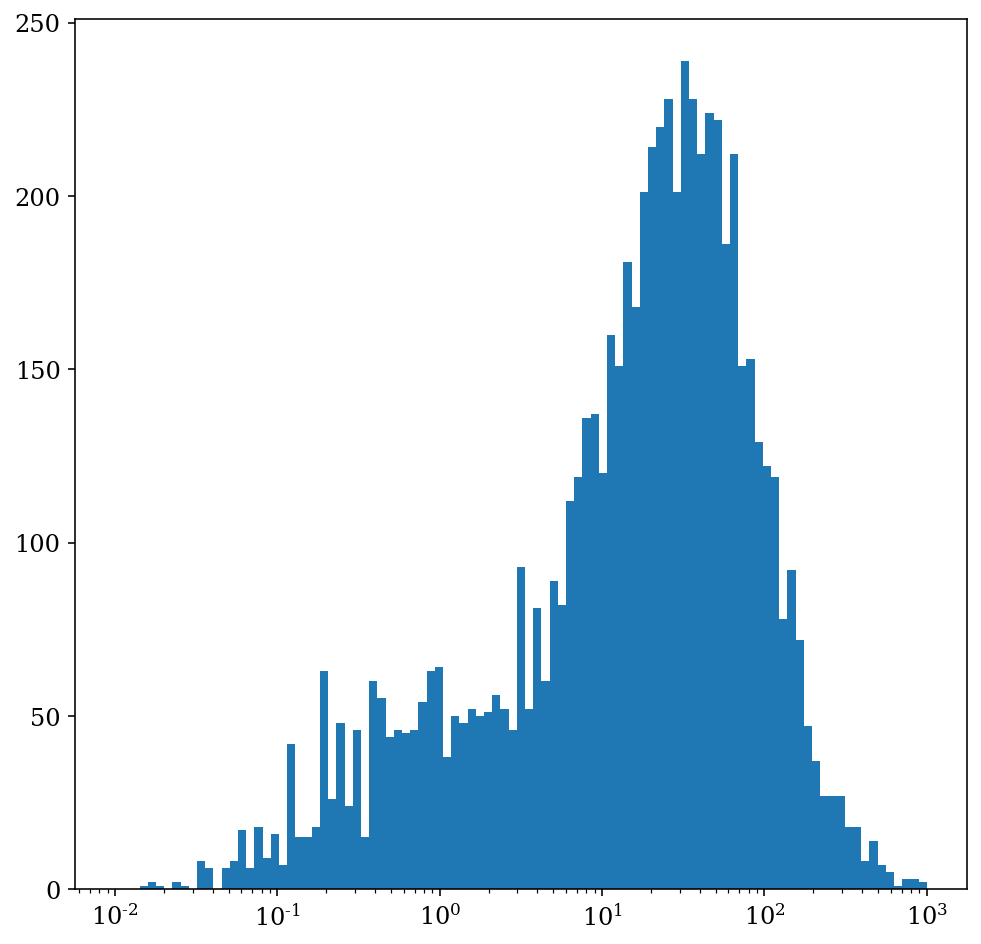

In [25]:
#histogram
plt.hist(T90_masked, bins = np.logspace(-2, 3, 100))
plt.semilogx()
plt.show()

In [85]:
#kde
logT90 = np.log10(T90_masked)[:, np.newaxis]

kde = KernelDensity(kernel='gaussian', bandwidth=0.08).fit(logT90)

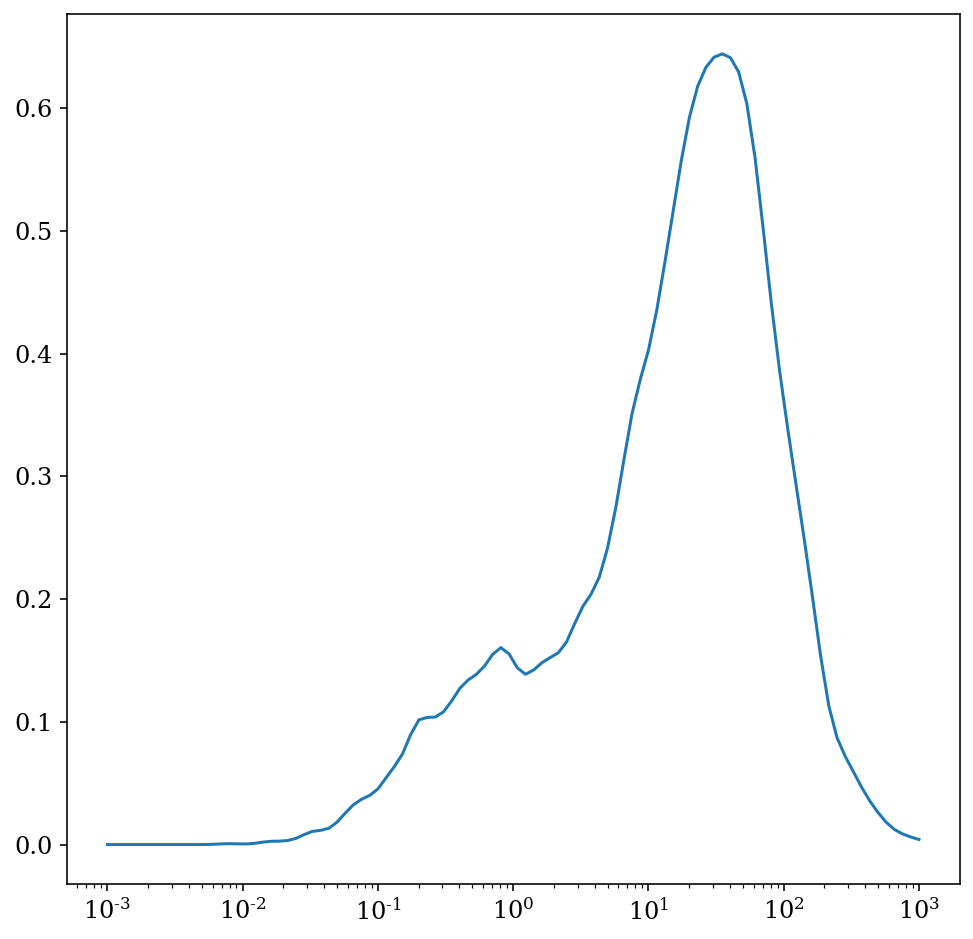

In [44]:
xgrid = np.logspace(-3, 3, 100)
plt.plot(xgrid, np.exp(kde.score_samples(np.log10(xgrid)[:, np.newaxis])))
plt.semilogx()
plt.show()

In [86]:
clf.fit(logT90)

KMeans(n_clusters=2)

In [93]:
T90_centers = 10**clf.cluster_centers_[:,0]
T90_labels = clf.predict(logT90)

if T90_centers[0] > T90_centers[1]:
    T90_centers = T90_centers[::-1]
    T90_labels = np.array(~np.array(T90_labels,dtype='bool'),dtype='int')
print('the centers are at T90 = %.2f s and T90 = %.2f s' % (T90_centers[0], T90_centers[1]))

the centers are at T90 = 0.91 s and T90 = 33.82 s


In [98]:
separation = 10**(np.mean([max(logT90[T90_labels == 0]), min(logT90[T90_labels == 1])]) )

In [ ]:
plt.plot(xgrid, np.exp(kde.score_samples(np.log10(xgrid)[:, np.newaxis])))
for cen in T90_centers:
    plt.axvline(cen, c = 'r', ls = '--')
plt.semilogx()
plt.show()

In [99]:
#gaussian mixture
gm = GaussianMixture(2).fit(logT90)

means = 10**gm.means_[:,0]

if means[0] > means[1]:
    means = means[::-1]

In [100]:
means

array([ 0.96650962, 31.34614195])

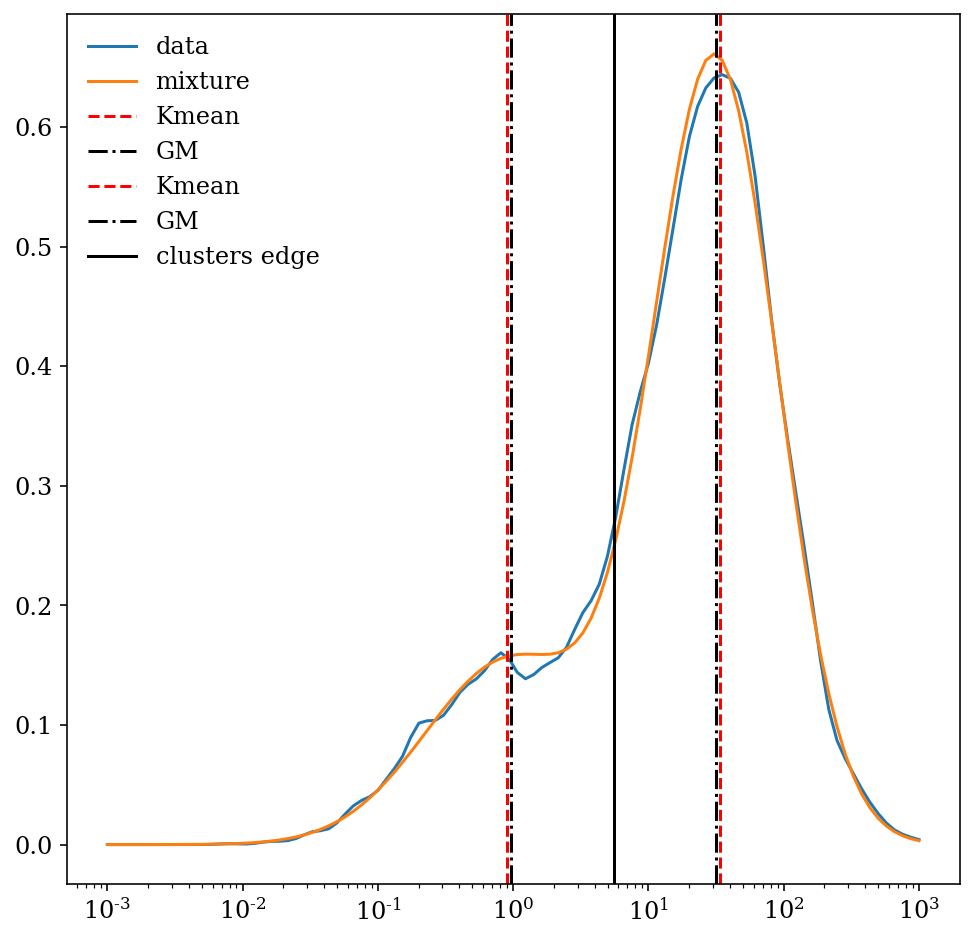

In [103]:
plt.plot(xgrid, np.exp(kde.score_samples(np.log10(xgrid)[:, np.newaxis])), label = 'data')
plt.plot(xgrid, np.exp(gm.score_samples(np.log10(xgrid)[:, np.newaxis])), label = 'mixture')

for cen, mean in zip(T90_centers, means):
    plt.axvline(cen, c = 'r', ls = '--', label = 'Kmean')
    plt.axvline(mean, c = 'k', ls = '-.', label = 'GM')

plt.axvline(separation, c = 'k', ls = '-', label = 'clusters edge')
    
plt.semilogx()
plt.legend(frameon = False)
plt.show()

clustering and gaussian mixture give similar outcomes.

## redshift

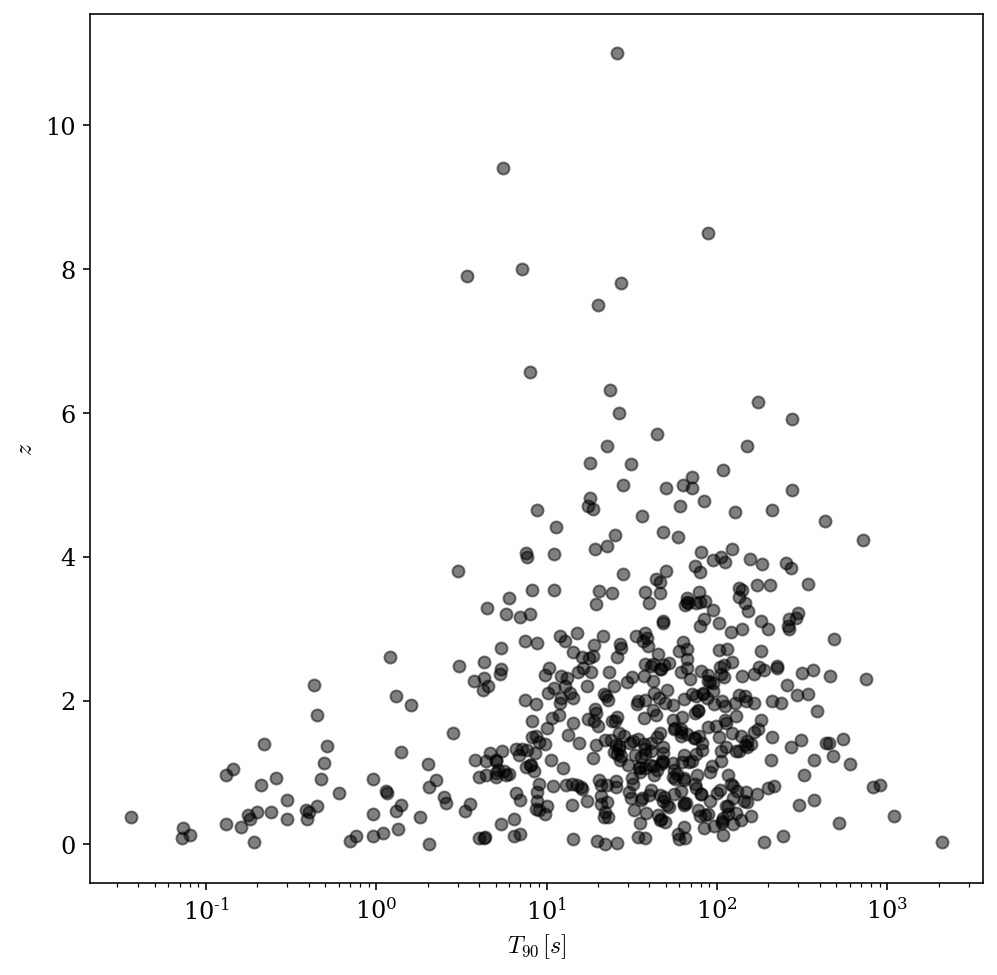

In [21]:
z = data[11].astype(float)

mask = (T90 > 0) & (z > 0)

plt.scatter(T90[mask], z[mask], c = 'k', alpha = 0.5)


plt.xlabel(r'$T_{90}\, [s]$')
plt.ylabel(r'$z$')
plt.xscale('log')
#plt.loglog()
plt.show()

sGRBs close and lGRBs far?